# MLB Piecewise Regression Test

This notebook is a test of the use of a piecewise linear regression model for the prediction of player statistics.  In this model, the data is divided into buckets using a decision tree regressor.  A piecewise regression model from MLInsights (Scikit Learn extention) fits one line per bin to the data.

This is a preliminary test into the feasibility of this model as an option for the course project.

## Setup Notebook

In [9]:
# Import 3rd party libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Import libraries for piecewise classification
from sklearn.model_selection import train_test_split
from mlinsights.mlmodel import PiecewiseRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA

# Configure notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

## Data Import

The individual yearly mlb data files have already been preprocessed and cleaned according to the project requirements.  Each year's data is in a separate .csv file, they will be compiled into a single dataframe for ease of data management.

In [11]:
# Create a list of player data filenames 
mlb_filenames = [file for file in os.listdir() if file.find('_complete') != -1]
# Create an empty dataframe for player data
mlb_data = pd.DataFrame()

# Read each player data .csv file into a dataframe, and add it to the total mlb data
for file in mlb_filenames:
    file_data = pd.read_csv(file)
    mlb_data = pd.concat([mlb_data, file_data], ignore_index = True)
    
# View Dataframe
mlb_data.head()

,Unnamed: 0,full_name,player_id,year,player_age,league,rank,vote_points,1st_place,mvp_share,...,b_triple,b_home_run,b_strikeout,b_walk,b_k_percent,b_bb_percent,batting_avg,slg_percent,on_base_percent,on_base_plus_slg
0,17,Mike Trout,545361.0,2013,22,AL,2.0,282.0,5.0,0.67,...,9.0,27.0,136.0,110.0,19.0,15.4,0.323,0.557,0.432,0.988
1,21,Clayton Kershaw,477132.0,2013,25,NL,7.0,146.0,0.0,0.35,...,0.0,1.0,24.0,5.0,26.1,5.4,0.182,0.260,0.217,0.477
2,48,Andrew McCutchen,457705.0,2013,27,NL,1.0,409.0,28.0,0.97,...,5.0,21.0,101.0,78.0,15.0,11.6,0.317,0.508,0.404,0.911
3,60,Carlos Gomez,460576.0,2013,28,NL,9.0,43.0,0.0,0.10,...,10.0,24.0,146.0,37.0,24.7,6.3,0.284,0.506,0.337,0.843
4,64,Miguel Cabrera,408234.0,2013,30,AL,1.0,385.0,23.0,0.92,...,1.0,44.0,94.0,90.0,14.4,13.8,0.348,0.636,0.442,1.078


## Data Processing

The first step of the data processing pipeline is to remove outlier data.  These values can greatly influence the model training data.

Based on historical MVP winner data, the following baseline stat can be used to eliminate outlying players:
- Total WAR < 2.00
- Batting Average < 0.250
- On-Base Percentage < 0.300

Although other features are used in the MVP voting predicition, these two statistics are the standard of player excellence and are basic statistics used to measure player efficiency. An MVP calibre player should maintain this baseline of stats.  Players who do not meet this standard will be eliminated from contention.  The elimination of these outliers will also help tune the model to the trajectory of an above-average player's statistics.

The following function removes outliers that are outside of a specified upper and lower limit.

In [3]:
# Create a function to eliminate outlier data based on specific upper and lower limits for a column value
def remove_outliers(data):
    """
    Input:
      data (data frame): dataframe to be filtered    
    Output:
      data frame with outliers removed
    """
      
    # Trim the data to column values above the lower threshold
    data = data[data['Total_WAR'] > 2.00]
    data = data[data['batting_avg'] > 0.250]
    data = data[data['on_base_percent'] > 0.300]
    
    # Add 2022 player data (spreadsheet is blank)
    active_players = data['full_name'].unique()
    data_2022 = pd.read_csv("2022_complete.csv")
    data_2022 = data_2022.loc[data_2022['full_name'].isin(active_players)]
    
    data = pd.concat([data, data_2022], ignore_index = True)
    
    # Return the intermediate dataframe
    return data

Secondly, the selected model features must be extracted from the input dataset.  These are the specific features that will be used in the MVP prediction model (separate from this function).  Any columns that are not required for the MVP preduction will not be subjected to forecasting.

To properly predict a player's future behaviour, this function is time-based and specific for each individual player, it will be a careful process to choose the deciding features.  To accurately determine player statistics for a year, it will be a function of the following:
- player age
- statistics for the past 3 years for each feature

Since this is a "dynamic" form of input, the player names for the testing year will need to be inputted and cross-referenced with the current data.

In [4]:
# Create a function to gather the current and past 3 years of statistics for a list of players active in a given year
def select_stats(data, year, column):
    """
    Input:
        data (dataframe): the table of player data to be referenced
        year (integer): year in reference
        column (strings): column name of the statistics required
    Output:
        compiled_data (dataframe): 
    """
    # Create a list of players active in the current year
    players = data[data["year"]==year]['full_name'].unique()
    
    # Create 3 individual lists for the statistics in the current year, last year, 2 years ago, and 3 years ago
    ages = []
    stats = []
    stats_1 = []
    stats_2 = []
    stats_3 = []
    leagues = []
    
    # Loop through each current active player
    for player in players:
        stats.append(data[data['year'] == year].set_index('full_name').loc[player,column])  # Add the current year stat
        
        ages.append(data[data['year'] == (year)].set_index('full_name').loc[player,"player_age"])  # Add the player's age
        
        leagues.append(data[data['year'] == (year)].set_index('full_name').loc[player,"league"])
        # For each year, search if the player was active.  If so, add their yearly statistic to the appropriate list.
        # If inactive, add a 0 to the list.
        if player in data[data["year"]==(year-1)]['full_name'].unique():
            stats_1.append(data[data['year'] == (year-1)].set_index('full_name').loc[player,column])
        else:
            stats_1.append(0)
            
        if player in data[data["year"]==(year-2)]['full_name'].unique():
            stats_2.append(data[data['year'] == (year-2)].set_index('full_name').loc[player,column])
        else:
            stats_2.append(0)
            
        if player in data[data["year"]==(year-3)]['full_name'].unique():
            stats_3.append(data[data['year'] == (year-3)].set_index('full_name').loc[player,column])
        else:
            stats_3.append(0)
    
    # Create a dataframe that compiles the statistics into one source
    compiled_data = pd.DataFrame(players, columns=['name'])
    compiled_data["player_age"] = ages
    compiled_data["league"] = leagues
    compiled_data["current_year"] = stats
    compiled_data["1_year"] = stats_1
    compiled_data["2_years"] = stats_2
    compiled_data["3_years"] = stats_3
    
    # Return the completed dataframe
    return compiled_data

Finally, these functions should be combined to create a data processing function that removes outliers, selects the appropriate columns when given a dataset, year of interest, and statistic of interest, and returns the X and y datasets for training. 

In [5]:
# Create an aggregate function for the data processing pipeline elements.
def process_data(data, year, statistic):
    """
    Input:
        data (dataframe): the table of player data to be referenced
        year (integer): year in reference
        statistic (string): column name of the statistics required
    Output:
        X (dataframe): dataset containing feature values
        y (series): series containing prediction target values
    """
    
    # Remove outlier data according to the acceptable BA and OBP thresholds.
    data = remove_outliers(data)
    
    # Select the feature columns from past data for the given statistic
    feature_data = select_stats(data, year, statistic)
    
    # Return predictors and response variables separately
    X = feature_data.drop(['current_year','name',"league"], axis = 1)
    y = feature_data.loc[:, 'current_year']
    players = feature_data.loc[:, ["name","league"]]
    
    return X, y, players

Let's test out the function for years 2015 and 2018.

In [12]:
X_function, y_function, player_list = process_data(mlb_data, 2022, "batting_avg")
print(X_function)
print(y_function)
print(player_list)

     player_age  1_year  2_years  3_years
0            31   0.000      0.0    0.273
1            31   0.000      0.0    0.261
2            21   0.288      0.0    0.000
3            27   0.000      0.0    0.291
4            31   0.000      0.0    0.000
..          ...     ...      ...      ...
190          34   0.000      0.0    0.273
191          31   0.000      0.0    0.274
192          35   0.000      0.0    0.000
193          25   0.000      0.0    0.255
194          29   0.000      0.0    0.305

[195 rows x 4 columns]
0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
190   NaN
191   NaN
192   NaN
193   NaN
194   NaN
Name: current_year, Length: 195, dtype: float64
                name league
0         Tom Murphy     AL
1        Ji-Man Choi     AL
2      Wander Franco     AL
3     Austin Meadows     AL
4         Matt Duffy     AL
..               ...    ...
190       Tommy Pham     NL
191  Jonathan Villar     NL
192       Manny Pina     NL
193    Victor Robles     NL
194   

## Data Preparation

The MLB data will be divided into the following categories for training and validation purposes:
- Training Data: 2011-2018
- Validation Data: 2019-2021

The true target of this project is to forecast player data for the 2022 season.  The only information available about these players are their ages and past performance data, which are the features this forecasting model requires.  The 11 total years of training data will provide a sufficient model for above average player progression, as it's a large enough dataset to encapsulate a large amount of a player's career.  For example, a 24 year old player in 2008 at the beginning of his career will be 35 years old in 2018, well past his peak.  This allows for an entire career progression to be included in the model training.

The training data must be compiled from the results of the data processing for each year.  Additionally, the data must be separately processed for each statistic.  The following features have been selected for MVP prediction:
- Player Batting Average (BA)
- Number of Home Runs
- Number of Total Hits
- On Base Percentage (OBP)
- Batter WAR
- Player WAR

To make this process easier, a function will be created to concatenate all forecasted data for an number of years.

In [13]:
# Create a function that compiles feature data for a range of years
def get_feature_data(full_data, feat, year_start, year_stop):
    """
    Input:
        full_data (dataframe): dataset of total MLB data
        feat (string): name of feature to be extracted
        year_start (numeric): first year to be considered
        year_stop (numeric): last year to be considered
    Output:
        X_total (dataframe): compiled feature data
        y_total (dataframe): compiled result data
    """
    # Create an empty dataframe for feature data
    X_total = pd.DataFrame()
    y_total = pd.DataFrame()
    player_indices = pd.DataFrame()
    
    # Process the data for each year in the specified range and 
    for year in range(year_start, (year_stop+1)):
        X_process, y_process, players_process = process_data(full_data, year, feat)
        X_total = pd.concat([X_total, X_process], ignore_index = True)
        y_total = pd.concat([y_total, y_process], ignore_index = True).squeeze()
        player_indices = pd.concat([player_indices, players_process], ignore_index = True)
    
    return X_total, y_total, player_indices

Let's get the required training and validation datasets for the batting average.

In [14]:
X_train, y_train, players_train = get_feature_data(mlb_data, "batting_avg", 2011, 2018)
X_val, y_val, players_val = get_feature_data(mlb_data, "batting_avg", 2019, 2021)

In [15]:
print(X_train)
print(y_train)
print(players_train)

     player_age  1_year  2_years  3_years
0            28   0.000    0.301    0.280
1            31   0.260    0.000    0.000
2            27   0.000    0.297    0.290
3            28   0.288    0.296    0.326
4            28   0.304    0.320    0.285
..          ...     ...      ...      ...
837          28   0.294    0.294    0.000
838          29   0.259    0.000    0.293
839          26   0.000    0.000    0.000
840          35   0.283    0.000    0.000
841          26   0.000    0.000    0.000

[842 rows x 4 columns]
0      0.321
1      0.302
2      0.324
3      0.307
4      0.332
       ...  
837    0.253
838    0.270
839    0.290
840    0.271
841    0.258
Length: 842, dtype: float64
                 name league
0     Jacoby Ellsbury     AL
1       Jose Bautista     AL
2           Matt Kemp     NL
3      Dustin Pedroia     AL
4          Ryan Braun     NL
..                ...    ...
837   Cesar Hernandez     NL
838     Jason Heyward     NL
839  Michael Lorenzen     NL
840       K

## Model Training and Prediction

As mentioned before, this model will be a piecewise linear regressor from the MLInsights package.  It will be sorted into two bins to model the average increasing and decreasing trends over the course of a player's career.

This bi-linear piecewise regression model was selected because of the average trend of a player's statistic set over  the course of his career.  They tend to improve (at different rates) before the middle of their career, where they peak in performance.  After this point, players decline (again, at different rates).  This model will accurately reflect the average rate of change per statistics.

A decision tree regressor will carry this out, and a minimum number of data points (leaves) will be specified to determine a splitting point.  The model will then accept this bin categorization for the piecewise regressor.

In [16]:
# Sort the data into bins with a minimum number of samples needed to determine bin boundaries.
bins = DecisionTreeRegressor(min_samples_leaf=150)

# Set the model to a piecewise regressor that accepts the decision tree regressor as bin boundaries.
model = PiecewiseRegressor(verbose=True, binner=bins)

In [17]:
# Fit the model to the training data
model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


PiecewiseRegressor(binner=DecisionTreeRegressor(min_samples_leaf=150),
                   estimator=LinearRegression(), verbose=True)

In [18]:
print(X_val)

     player_age  1_year  2_years  3_years
0            25   0.286    0.284    0.000
1            24   0.260    0.267    0.000
2            29   0.255    0.000    0.000
3            28   0.312    0.306    0.315
4            27   0.346    0.264    0.318
..          ...     ...      ...      ...
235          27   0.000    0.296    0.286
236          30   0.000    0.000    0.000
237          30   0.000    0.273    0.000
238          34   0.000    0.000    0.000
239          41   0.000    0.311    0.256

[240 rows x 4 columns]


<AxesSubplot:>

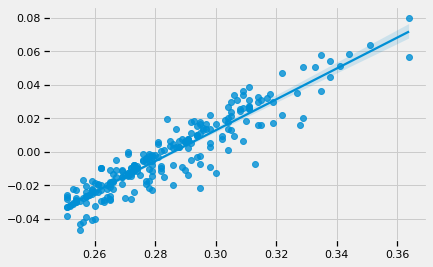

In [19]:
# Create a residual plot for the validation data
pred = model.predict(X_val)
residuals = y_val - pred
sns.regplot(y_val, residuals)

In [20]:
print(pd.Series(pred))
print(y_val)

0      0.283060
1      0.275277
2      0.278297
3      0.304608
4      0.316372
         ...   
235    0.297576
236    0.282088
237    0.272683
238    0.284383
239    0.286141
Length: 240, dtype: float64
0      0.296
1      0.305
2      0.285
3      0.291
4      0.295
       ...  
235    0.270
236    0.267
237    0.256
238    0.252
239    0.265
Length: 240, dtype: float64


In [21]:
plot_data = pd.concat([y_val, pd.Series(pred), X_val["player_age"]], axis=1, ignore_index = True)
plot_data.columns = ["True Value", "Predicted Value", "Player Age"]
print(plot_data)
plot_data = pd.melt(plot_data, id_vars=["Player Age"], value_vars=["True Value", "Predicted Value"])
print(plot_data)

     True Value  Predicted Value  Player Age
0         0.296         0.283060          25
1         0.305         0.275277          24
2         0.285         0.278297          29
3         0.291         0.304608          28
4         0.295         0.316372          27
..          ...              ...         ...
235       0.270         0.297576          27
236       0.267         0.282088          30
237       0.256         0.272683          30
238       0.252         0.284383          34
239       0.265         0.286141          41

[240 rows x 3 columns]
     Player Age         variable     value
0            25       True Value  0.296000
1            24       True Value  0.305000
2            29       True Value  0.285000
3            28       True Value  0.291000
4            27       True Value  0.295000
..          ...              ...       ...
475          27  Predicted Value  0.297576
476          30  Predicted Value  0.282088
477          30  Predicted Value  0.272683
478   

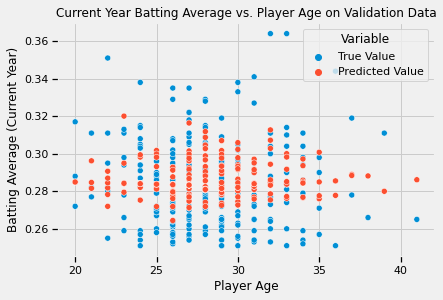

In [22]:
plot_BA = sns.scatterplot(data=plot_data, x="Player Age", y="value", hue="variable")
plot_BA.set_xlabel('Player Age')
plot_BA.set_ylabel('Batting Average (Current Year)')
plot_BA.set_title("Current Year Batting Average vs. Player Age on Validation Data");
plot_BA.legend(title="Variable")

## Aggregate Modelling Function

Now that workflows for data collection, model generation, and visualizations have been established, it's time to put it all together.

The final function for this project should combine all workflows within this notebook to produce a dataframe of predicted statistics for a player in 2022, as well as visualization plots for all statistic models.  The function will work as follows:
1) Collect historial statistics for all considered features.

2) Gather model training data for each statistic.

3) Create individual models for each feature.

4) Train each model from the produced training data.

5) Create a predicted set of data for each statistic.

6) Produce prediction visualizations and residual plots for each model performance.

7) Return a dataframe with the compiled player predictions with input for the MVP prediction model.

8) Export dataframe into a .csv file.

In [23]:
def create_residual_plot(validation, prediction, feature):
    plt.figure()
    residuals = validation - prediction
    plot = sns.regplot(validation, residuals)
    plot.set_xlabel(feature)
    plot.set_ylabel('Validation Residuals')
    plot.set_title(feature + " Validation Residuals")

In [24]:
def create_comparison_plot(val_results, prediction, val_data, feature):
    plot_data = pd.concat([val_results, pd.Series(prediction), val_data["player_age"]], axis=1, ignore_index = True)
    plot_data.columns = ["True Value", "Predicted Value", "Player Age"]
    plot_data = pd.melt(plot_data, id_vars=["Player Age"], value_vars=["True Value", "Predicted Value"])
     
    plt.figure()
    plot = sns.scatterplot(data=plot_data, x="Player Age", y="value", hue="variable")
    plot.set_xlabel('Player Age')
    plot.set_ylabel(feature + ' (Current Year)')
    plot.set_title("Current " + feature + " vs. Player Age on Validation Data");
    plot.legend(title="Variable")
    plot

In [42]:
def stat_forecast(data, year=2022, min_samples_leaf=40):
    
    features = ["WAR_bat", "WAR_pit", "batting_avg", "b_home_run", "b_total_hits", "on_base_percent"]
    forecast = pd.DataFrame()
    
    for feature in features:
        X_train, y_train, players_train = get_feature_data(mlb_data, feature, 2011, 2018)
        X_val, y_val, players_val = get_feature_data(mlb_data, feature, 2019, 2021)
        X_test, y_test, players_test = get_feature_data(mlb_data, feature, year, year)
        
        # Sort the data into bins with a minimum number of samples needed to determine bin boundaries.
        bins = DecisionTreeRegressor(min_samples_leaf=min_samples_leaf)

        # Set the model to a piecewise regressor that accepts the decision tree regressor as bin boundaries.
        model = PiecewiseRegressor(verbose=True, binner=bins)
        
        # Fit the model to the training data and perform a prediction on the validation data
        model.fit(X_train, y_train)
        pred = model.predict(X_val)
    
        res_plot = create_residual_plot(y_val, pred, feature)   # Create a residual plot for the validation data   
        comp_plot = create_comparison_plot(y_val, pred, X_val, feature)  # Create a plot comparing the actual and predicted validation data
        
        forecast[feature] = model.predict(X_test)  # Add predicted feature to forecast dataframe
    forecast.head()
    
    forecast["name"] = players_test["name"]  # Add the names of the players
    forecast["league"] = players_test["league"]
    forecast["year"] = year
    forecast.to_csv('stat_forecast.csv')
    return forecast

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s finished


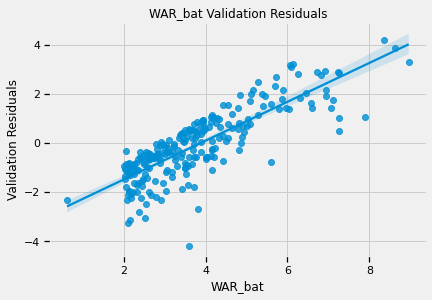

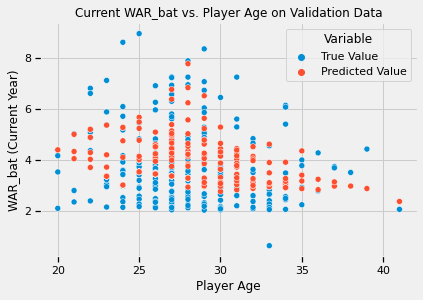

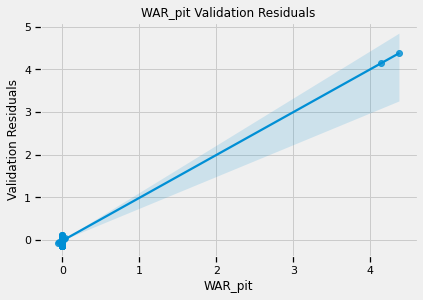

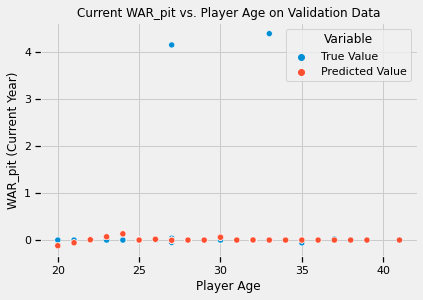

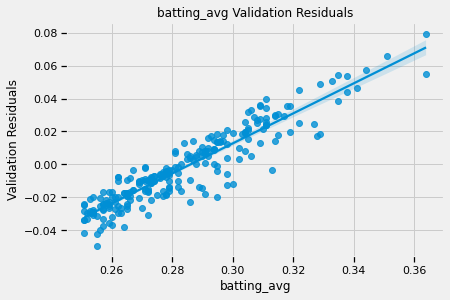

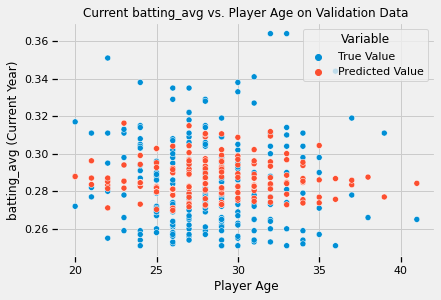

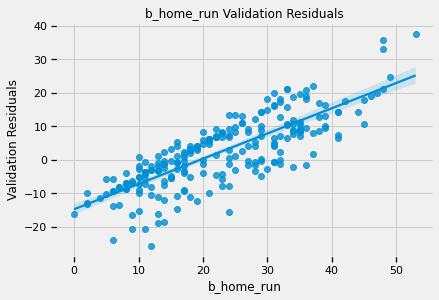

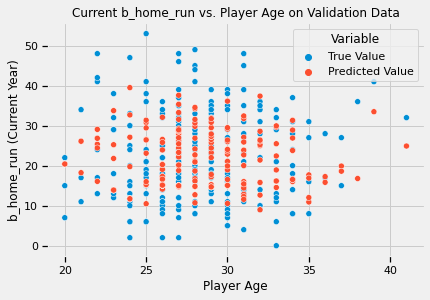

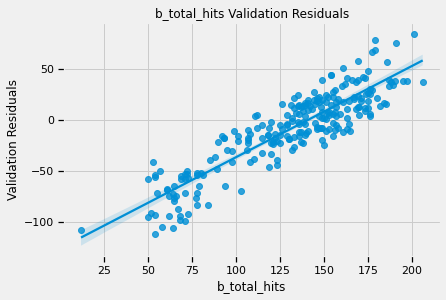

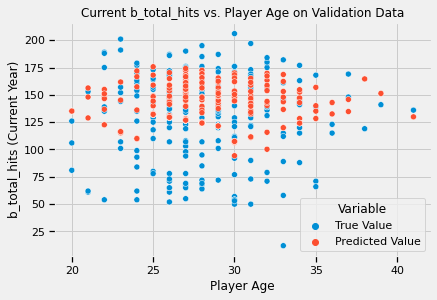

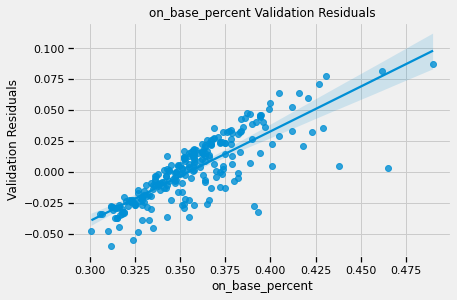

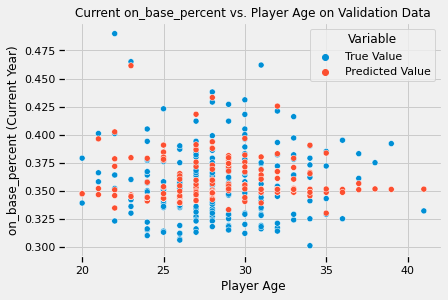

In [41]:
forecast = stat_forecast(mlb_data, 2021, min_samples_leaf=75)